# Import

In [ ]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

# Abbassiamo la precisione per aumentare l'efficienza
torch.set_float32_matmul_precision('high')

# Download, caricamento e pulizia del dataset

In [ ]:
!gdown 17yUUZ09nMzfWyTELILDd-KjiNoFv8Kfo
!unzip '/content/snli_1.0.zip'

Downloading...
From (original): https://drive.google.com/uc?id=17yUUZ09nMzfWyTELILDd-KjiNoFv8Kfo
From (redirected): https://drive.google.com/uc?id=17yUUZ09nMzfWyTELILDd-KjiNoFv8Kfo&confirm=t&uuid=1cca2522-d4e2-4d02-938d-2794399bf5ff
To: /content/snli_1.0.zip
100% 94.6M/94.6M [00:01<00:00, 65.2MB/s]
Archive:  /content/snli_1.0.zip
   creating: snli_1.0/
  inflating: snli_1.0/.DS_Store      
   creating: __MACOSX/
   creating: __MACOSX/snli_1.0/
  inflating: __MACOSX/snli_1.0/._.DS_Store  
 extracting: snli_1.0/Icon           
  inflating: __MACOSX/snli_1.0/._Icon  
  inflating: snli_1.0/README.txt     
  inflating: __MACOSX/snli_1.0/._README.txt  
  inflating: snli_1.0/snli_1.0_dev.jsonl  
  inflating: snli_1.0/snli_1.0_dev.txt  
  inflating: snli_1.0/snli_1.0_test.jsonl  
  inflating: snli_1.0/snli_1.0_test.txt  
  inflating: snli_1.0/snli_1.0_train.jsonl  
  inflating: snli_1.0/snli_1.0_train.txt  
  inflating: __MACOSX/._snli_1.0     


I dati sono già suddivisi in tre file diversi per training, validation e test. Li carichiamo e analizziamo separatamente.

### Training set

In [ ]:
path = '/content/snli_1.0/snli_1.0_train.txt'

train_df = pd.read_csv(path, delimiter='\t')
train_df.head()

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,neutral,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( is ( ( training ( his horse...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,3416050480.jpg#4,3416050480.jpg#4r1n,neutral,NaN,NaN,NaN,NaN
1,contradiction,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( ( ( is ( at ( a diner ) ) )...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",3416050480.jpg#4,3416050480.jpg#4r1c,contradiction,NaN,NaN,NaN,NaN
2,entailment,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,"( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...",(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",3416050480.jpg#4,3416050480.jpg#4r1e,entailment,NaN,NaN,NaN,NaN
3,neutral,( Children ( ( ( smiling and ) waving ) ( at c...,( They ( are ( smiling ( at ( their parents ) ...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VB...,Children smiling and waving at camera,They are smiling at their parents,2267923837.jpg#2,2267923837.jpg#2r1n,neutral,NaN,NaN,NaN,NaN
4,entailment,( Children ( ( ( smiling and ) waving ) ( at c...,( There ( ( are children ) present ) ),(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NN...,Children smiling and waving at camera,There are children present,2267923837.jpg#2,2267923837.jpg#2r1e,entailment,NaN,NaN,NaN,NaN


In [ ]:
train_df.describe()

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
count,550152,550152,550146,550152,550152,550152,550146,550152,550152,550152,39370,39395,39383,36914
unique,4,150736,479906,150736,479908,150736,480040,151196,550152,3,3,3,3,3
top,entailment,( ( ( A dog ) ( in ( a field ) ) ) . ),( ( A man ) ( ( is sleeping ) . ) ),(ROOT (NP (NP (DT A) (NN dog)) (PP (IN in) (NP...,(ROOT (S (NP (DT A) (NN man)) (VP (VBZ is) (VP...,A dog in a field.,A man is sleeping.,7261359916.jpg#2,7979219683.jpg#2r1e,neutral,contradiction,contradiction,contradiction,entailment
freq,183416,33,335,33,335,33,335,15,1,183384,13478,13728,13701,12768


In [ ]:
# Controlliamo quanti valori mancanti ci sono
train_df.isna().sum()

,0
gold_label,0
sentence1_binary_parse,0
sentence2_binary_parse,6
sentence1_parse,0
sentence2_parse,0
sentence1,0
sentence2,6
captionID,0
pairID,0
label1,0


I valori mancanti nelle label non ci interessano perché non useremo quelle feature. Per il resto ci sono solo 6 valori mancanti in sentence2, quindi procediamo a eliminarli.

In [ ]:
# Elimiamo i valori mancanti e verifichiamo che la modifica sia andata a buon fine
train_df.dropna(subset=['sentence2'], inplace=True)
train_df.isna().sum()

,0
gold_label,0
sentence1_binary_parse,0
sentence2_binary_parse,0
sentence1_parse,0
sentence2_parse,0
sentence1,0
sentence2,0
captionID,0
pairID,0
label1,0


Controlliamo quali saranno le nostre classi in gold_label.

In [ ]:
train_df['gold_label'].unique()

array(['neutral', 'contradiction', 'entailment', '-'], dtype=object)

Notiamo che oltre a 'Entailment', 'Contradiction' e 'Neutral' c'è un trattino in gold_label. Vediamo quanti sample hanno il trattino per decidere come trattarli.

In [ ]:
trattino = train_df[train_df['gold_label'] == '-'].shape[0]
print(f'Le righe in cui "gold_label" è "-" sono {trattino}, che corrisponde al {trattino / train_df.shape[0] * 100:.2f}% del totale')

Le righe in cui "gold_label" è "-" sono 785, che corrisponde al 0.14% del totale


Vediamo come sono fatti i sample in cui gold_label è -.

In [ ]:
train_df[train_df['gold_label'] == '-'].head()

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
145,-,( ( ( A ( small group ) ) ( of church-goers ) ...,( ( A choir ) ( ( performs ( in ( front ( of (...,(ROOT (S (NP (NP (DT A) (JJ small) (NN group))...,(ROOT (S (NP (DT A) (NN choir)) (VP (VBZ perfo...,A small group of church-goers watch a choir pr...,A choir performs in front of packed crowd.,2677109430.jpg#2,2677109430.jpg#2r1c,contradiction,contradiction,neutral,neutral,NaN
783,-,( ( ( A woman ) ( wearing ( a ( pink hat ) ) )...,( ( The woman ) ( ( is ( wearing clothes ) ) ....,(ROOT (S (NP (NP (DT A) (NN woman)) (VP (VBG w...,(ROOT (S (NP (DT The) (NN woman)) (VP (VBZ is)...,A woman wearing a pink hat is looking at a pin...,The woman is wearing clothes.,226630666.jpg#1,226630666.jpg#1r1e,entailment,entailment,neutral,neutral,contradiction
1562,-,( man ( in ( ( red ( canada shirt ) ) ( standi...,( ( Man standing ) ( with ( ( three men ) ( in...,(ROOT (NP (NP (NN man)) (PP (IN in) (NP (NP (J...,(ROOT (NP (NP (NN Man) (NN standing)) (PP (IN ...,man in red canada shirt standing with three me...,Man standing with three men in army uniform ne...,179172576.jpg#3,179172576.jpg#3r1n,neutral,contradiction,entailment,contradiction,neutral
2593,-,( ( ( ( A man ) ( in ( a ( white jacket ) ) ) ...,( ( The man ) ( ( was ( ( playing crochet ) ( ...,(ROOT (NP (NP (NP (DT A) (NN man)) (PP (IN in)...,(ROOT (S (NP (DT The) (NN man)) (VP (VBD was) ...,A man in a white jacket standing in front of a...,The man was playing crochet with the two women.,4926115712.jpg#0,4926115712.jpg#0r1n,neutral,contradiction,neutral,contradiction,entailment
2881,-,( ( ( A ( swimmer 's ) ) hand ) ( ( is ( taken...,( ( The swimmer ) ( ( is female ) . ) ),(ROOT (S (NP (NP (DT A) (NN swimmer) (POS 's))...,(ROOT (S (NP (DT The) (NN swimmer)) (VP (VBZ i...,A swimmer's hand is taken as he gets out of th...,The swimmer is female.,7249180494.jpg#2,7249180494.jpg#2r1n,neutral,neutral,contradiction,contradiction,NaN


Si tratta di sample in cui, per vari motivi, gli annotatori non sono giunti a una decisione finale.
Poiché i sample con il trattino costituiscono solo una piccola parte del totale, li eliminiamo e verifichiamo che la modifica sia andata a buon fine.

In [ ]:
train_df = train_df[train_df['gold_label'] != '-']
train_df['gold_label'].unique()

array(['neutral', 'contradiction', 'entailment'], dtype=object)

Teniamo solo 'gold_label', 'sentence1' e 'sentence2', dal momento che le altre feature sono fatte per modelli che non utilizzeremo e riteniamo che le annotazioni non siano utili per l'addestramento del modello.

In [ ]:
train_df = train_df[['gold_label', 'sentence1', 'sentence2']]
train_df.head()

,gold_label,sentence1,sentence2
0,neutral,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.
1,contradiction,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette."
2,entailment,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse."
3,neutral,Children smiling and waving at camera,They are smiling at their parents
4,entailment,Children smiling and waving at camera,There are children present


Seguiamo esattamente lo stesso procedimento per validation e test set.

In [ ]:
path = '/content/snli_1.0/snli_1.0_dev.txt'

val_df = pd.read_csv(path, delimiter='\t')
val_df.head()

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,neutral,( ( Two women ) ( ( are ( embracing ( while ( ...,( ( The sisters ) ( ( are ( ( hugging goodbye ...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,(ROOT (S (NP (DT The) (NNS sisters)) (VP (VBP ...,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...,4705552913.jpg#2,4705552913.jpg#2r1n,neutral,entailment,neutral,neutral,neutral
1,entailment,( ( Two women ) ( ( are ( embracing ( while ( ...,( ( Two woman ) ( ( are ( holding packages ) )...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,(ROOT (S (NP (CD Two) (NN woman)) (VP (VBP are...,Two women are embracing while holding to go pa...,Two woman are holding packages.,4705552913.jpg#2,4705552913.jpg#2r1e,entailment,entailment,entailment,entailment,entailment
2,contradiction,( ( Two women ) ( ( are ( embracing ( while ( ...,( ( The men ) ( ( are ( fighting ( outside ( a...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,(ROOT (S (NP (DT The) (NNS men)) (VP (VBP are)...,Two women are embracing while holding to go pa...,The men are fighting outside a deli.,4705552913.jpg#2,4705552913.jpg#2r1c,contradiction,contradiction,contradiction,contradiction,contradiction
3,entailment,( ( ( Two ( young children ) ) ( in ( ( ( ( ( ...,( ( ( Two kids ) ( in ( numbered jerseys ) ) )...,(ROOT (S (NP (NP (CD Two) (JJ young) (NNS chil...,(ROOT (S (NP (NP (CD Two) (NNS kids)) (PP (IN ...,"Two young children in blue jerseys, one with t...",Two kids in numbered jerseys wash their hands.,2407214681.jpg#0,2407214681.jpg#0r1e,entailment,entailment,entailment,entailment,entailment
4,neutral,( ( ( Two ( young children ) ) ( in ( ( ( ( ( ...,( ( ( Two kids ) ( at ( a ballgame ) ) ) ( ( w...,(ROOT (S (NP (NP (CD Two) (JJ young) (NNS chil...,(ROOT (S (NP (NP (CD Two) (NNS kids)) (PP (IN ...,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.,2407214681.jpg#0,2407214681.jpg#0r1n,neutral,neutral,neutral,entailment,entailment


In [ ]:
val_df.describe()

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,9986
unique,4,3319,9818,3319,9818,3319,9819,3319,10000,3,3,3,3,3
top,entailment,( ( ( A man ) ( in ( ( ( a ( blue ( plaid shir...,( ( A man ) ( ( is outside ) . ) ),(ROOT (S (NP (NP (DT A) (NN man)) (PP (IN in) ...,(ROOT (S (NP (DT A) (NN man)) (VP (VBZ is) (AD...,"A man in a blue plaid shirt and blue jeans, we...",A man is outside.,699448056.jpg#0,4805835848.jpg#0r1n,entailment,entailment,entailment,entailment,entailment
freq,3329,6,6,6,6,6,6,6,1,3334,3396,3390,3429,3429


In [ ]:
# Verifichiamo se anche qui ci sono dei trattini
val_df['gold_label'].unique()

array(['neutral', 'entailment', 'contradiction', '-'], dtype=object)

In [ ]:
# Eliminiamo i sample con i trattini
val_df = val_df[val_df['gold_label'] != '-']
val_df['gold_label'].unique()

array(['neutral', 'entailment', 'contradiction'], dtype=object)

In [ ]:
# Selezioniamo le feature che ci interessano
val_df = val_df[['gold_label', 'sentence1', 'sentence2']]
val_df.head()

,gold_label,sentence1,sentence2
0,neutral,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...
1,entailment,Two women are embracing while holding to go pa...,Two woman are holding packages.
2,contradiction,Two women are embracing while holding to go pa...,The men are fighting outside a deli.
3,entailment,"Two young children in blue jerseys, one with t...",Two kids in numbered jerseys wash their hands.
4,neutral,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.


### Test set

In [ ]:
path = '/content/snli_1.0/snli_1.0_test.txt'

test_df = pd.read_csv(path, delimiter='\t')
test_df.head()

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,neutral,( ( This ( church choir ) ) ( ( ( sings ( to (...,( ( The church ) ( ( has ( cracks ( in ( the c...,(ROOT (S (NP (DT This) (NN church) (NN choir))...,(ROOT (S (NP (DT The) (NN church)) (VP (VBZ ha...,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,2677109430.jpg#1,2677109430.jpg#1r1n,neutral,contradiction,contradiction,neutral,neutral
1,entailment,( ( This ( church choir ) ) ( ( ( sings ( to (...,( ( The church ) ( ( is ( filled ( with song )...,(ROOT (S (NP (DT This) (NN church) (NN choir))...,(ROOT (S (NP (DT The) (NN church)) (VP (VBZ is...,This church choir sings to the masses as they ...,The church is filled with song.,2677109430.jpg#1,2677109430.jpg#1r1e,entailment,entailment,entailment,neutral,entailment
2,contradiction,( ( This ( church choir ) ) ( ( ( sings ( to (...,( ( ( A choir ) ( singing ( at ( a ( baseball ...,(ROOT (S (NP (DT This) (NN church) (NN choir))...,(ROOT (NP (NP (DT A) (NN choir)) (VP (VBG sing...,This church choir sings to the masses as they ...,A choir singing at a baseball game.,2677109430.jpg#1,2677109430.jpg#1r1c,contradiction,contradiction,contradiction,contradiction,contradiction
3,neutral,( ( ( A woman ) ( with ( ( ( ( ( a ( green hea...,( ( The woman ) ( ( is young ) . ) ),(ROOT (NP (NP (DT A) (NN woman)) (PP (IN with)...,(ROOT (S (NP (DT The) (NN woman)) (VP (VBZ is)...,"A woman with a green headscarf, blue shirt and...",The woman is young.,6160193920.jpg#4,6160193920.jpg#4r1n,neutral,neutral,neutral,neutral,neutral
4,entailment,( ( ( A woman ) ( with ( ( ( ( ( a ( green hea...,( ( The woman ) ( ( is ( very happy ) ) . ) ),(ROOT (NP (NP (DT A) (NN woman)) (PP (IN with)...,(ROOT (S (NP (DT The) (NN woman)) (VP (VBZ is)...,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,6160193920.jpg#4,6160193920.jpg#4r1e,entailment,entailment,contradiction,entailment,neutral


In [ ]:
test_df.describe()

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,9990
unique,4,3323,9810,3323,9810,3323,9810,3323,10000,3,3,3,3,3
top,entailment,( ( ( ( A man ) ( in ( ( ( a ( white ( striped...,( There ( ( are ( ( multiple people ) present ...,(ROOT (NP (NP (NP (DT A) (NN man)) (PP (IN in)...,(ROOT (S (NP (EX There)) (VP (VBP are) (ADJP (...,A man in a white striped shirt and blue jeans ...,There are multiple people present.,3843254402.jpg#0,152881593.jpg#1r1n,neutral,entailment,entailment,entailment,entailment
freq,3368,6,7,6,7,6,7,6,1,3334,3400,3439,3549,3543


In [ ]:
# Verifichiamo se anche qui ci sono dei trattini
test_df['gold_label'].unique()

array(['neutral', 'entailment', 'contradiction', '-'], dtype=object)

In [ ]:
# Eliminiamo i sample con i trattini
test_df = test_df[test_df['gold_label'] != '-']
test_df['gold_label'].unique()

array(['neutral', 'entailment', 'contradiction'], dtype=object)

In [ ]:
# Selezioniamo le feature che ci interessano
test_df = test_df[['gold_label', 'sentence1', 'sentence2']]
test_df.head()

,gold_label,sentence1,sentence2
0,neutral,This church choir sings to the masses as they ...,The church has cracks in the ceiling.
1,entailment,This church choir sings to the masses as they ...,The church is filled with song.
2,contradiction,This church choir sings to the masses as they ...,A choir singing at a baseball game.
3,neutral,"A woman with a green headscarf, blue shirt and...",The woman is young.
4,entailment,"A woman with a green headscarf, blue shirt and...",The woman is very happy.


# Exploratory Data Analysis

Per prima cosa verifichiamo se la distribuzione tra le classi è uguale tra training, validation e test set.

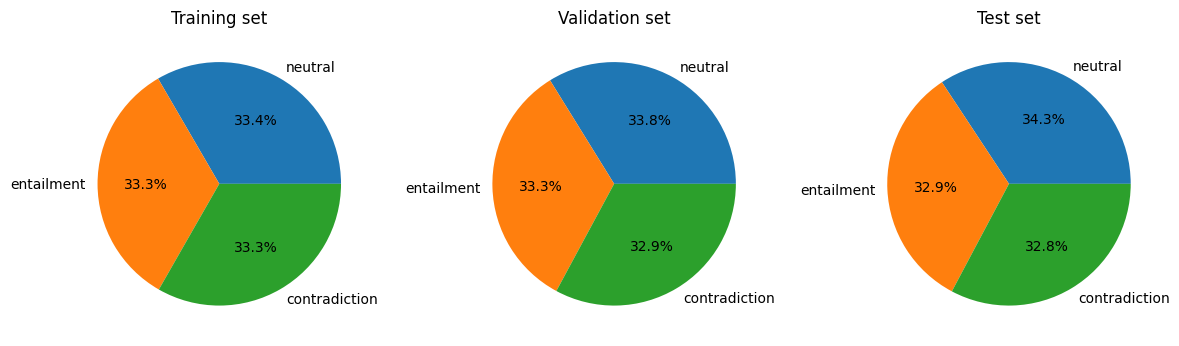

In [ ]:
# Distribuzione di gold_label
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
data1 = [train_df['gold_label'].value_counts(normalize=True).iloc[i] for i in range(0,3)]
data2 = [val_df['gold_label'].value_counts(normalize=True).iloc[i] for i in range(0,3)]
data3 = [test_df['gold_label'].value_counts(normalize=True).iloc[i] for i in range(0,3)]

keys = [f'{etichetta}' for etichetta in test_df['gold_label'].unique()]
axs[0].pie(data1, labels=keys, autopct='%.1f%%')
axs[0].set_title('Training set')

axs[1].pie(data2, labels=keys, autopct='%.1f%%')
axs[1].set_title('Validation set')

axs[2].pie(data3, labels=keys, autopct='%.1f%%')
axs[2].set_title('Test set')

plt.tight_layout()
plt.show()

Adesso studiamo la lunghezza media della premessa (sentence1) e dell'ipotesi (sentence2).

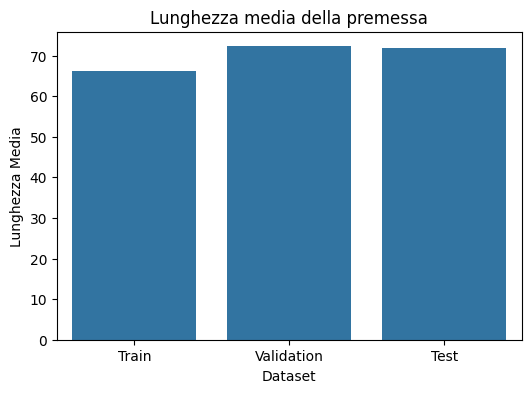

In [ ]:
# Premessa
p_len_train = np.mean([len(sentence) for sentence in train_df['sentence1']])
p_len_val = np.mean([len(sentence) for sentence in val_df['sentence1']])
p_len_test = np.mean([len(sentence) for sentence in test_df['sentence1']])


data = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'Lunghezza media': [p_len_train, p_len_val, p_len_test]
})

plt.figure(figsize=(6, 4))
sns.barplot(x='Dataset', y='Lunghezza media', data=data)

plt.ylabel('Lunghezza Media')
plt.title('Lunghezza media della premessa')
plt.show()

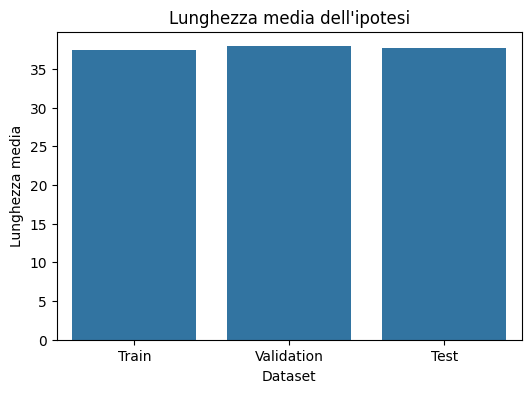

In [ ]:
# Ipotesi
h_len_train = np.mean([len(sentence) for sentence in train_df['sentence2']])
h_len_val = np.mean([len(sentence) for sentence in val_df['sentence2']])
h_len_test = np.mean([len(sentence) for sentence in test_df['sentence2']])


data = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'Lunghezza media': [h_len_train, h_len_val, h_len_test]
})

plt.figure(figsize=(6, 4))
sns.barplot(x='Dataset', y='Lunghezza media', data=data)

plt.ylabel('Lunghezza media')
plt.title('Lunghezza media dell\'ipotesi')
plt.show()

Dopo aver diviso l'input dalla target variable, codifichiamo gold_label usando LabelEncoder().

In [ ]:
le = LabelEncoder()

X_train = train_df[['sentence1', 'sentence2']]
y_train = le.fit_transform(train_df['gold_label'])

X_val = val_df[['sentence1', 'sentence2']]
y_val = le.transform(val_df['gold_label'])

X_test = test_df[['sentence1', 'sentence2']]
y_test = le.transform(test_df['gold_label'])

# Embedding

Useremo GloVe.

In [ ]:
# Scarichiamo gli embedding
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-05-05 07:05:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-05 07:05:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-05 07:05:59--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Tokenizziamo tutte le parole presenti SOLO nel training set e creiamo un dizionario che associa a ciascun token un indice. Aggiungiamo anche i token speciali <UNK> e <PAD>.

In [ ]:
# Inizializziamo il Counter
word_counter = Counter()

for i in range(X_train.shape[0]):
    sent1 = X_train.iloc[i]['sentence1']
    sent2 = X_train.iloc[i]['sentence2']

    # Tokenizziamo
    sent1 = re.findall(r'\w+', sent1.lower())
    sent2 = re.findall(r'\w+', sent2.lower())

    # Aggiorniamo il counter
    word_counter.update(sent1)
    word_counter.update(sent2)

# Aggiungiamo i token speciali
word2idx = {'<PAD>': 0, '<UNK>': 1}
for idx, word in enumerate(word_counter.keys(), 2):
    word2idx[word] = idx

# Salviamo la lunghezza del vocabolario
vocab_len = len(word2idx)
print(f'Lunghezza del vocabolario: {vocab_len} token')

Lunghezza del vocabolario: 33265 token


Useremo i vettori di dimensione 300, quindi carichiamo il file che li contiene. Creiamo un dizionario che associa a ogni token il vettore presente nel file.

In [ ]:
glove_path = 'glove.6B.300d.txt'

# Carichiamo gli embedding
embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

Creiamo l'embedding matrix, ossia una matrice che contiene i vettori associati a ciascuna parola presente nel nostro vocabolario. Se la parola non è presente nel dizionario, inizializziamo casualmente il vettore associato secondo la distribuzione normale.

In [ ]:
embedding_dim = 300

# Inizializziamo con tutti zeri
embedding_matrix = np.zeros((vocab_len, embedding_dim))

for word, idx in word2idx.items():
    if word in embeddings_index:
        embedding_matrix[idx] = embeddings_index[word]
    else:
        # Inizializziamo casualmente
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim, ))

# Creazione dei dataset e dataloader

Definiamo innanzitutto alcune funzioni di supporto.

In [ ]:
max_len = 80

def encode_tokens(tokens, word2idx, max_len=max_len):
    '''Prende in input i token e restituisce gli indici nel vocabolario che abbiamo costruito.'''
    indices = [word2idx.get(w, word2idx['<UNK>']) for w in tokens]
    if len(indices) < max_len:
        indices = indices + [word2idx['<PAD>']] * (max_len - len(indices))
    else:
        indices = indices[:max_len]

    return indices

def simple_collate(batch):
    sent1, sent2, labels = zip(*batch)
    return torch.stack(sent1), torch.stack(sent2), torch.tensor(labels)

Definiamo adesso la classe del dataset. All'interno di __get_item__ tokenizziamo le parole presenti nel dataset e applichiamo encode_tokens() per ottenere gli indici corrispondenti.

In [ ]:
class snli(Dataset):
    def __init__(self, X, y, word2idx, max_len):
        self.X = X
        self.y = y
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # Tokenizziamo
        sent1 = re.findall(r'\w+', self.X.iloc[idx]['sentence1'].lower())
        sent2 = re.findall(r'\w+', self.X.iloc[idx]['sentence2'].lower())

        # Convertiamo in indici
        sent1_idx = torch.tensor(encode_tokens(sent1, self.word2idx, self.max_len), dtype=torch.long)
        sent2_idx = torch.tensor(encode_tokens(sent2, self.word2idx, self.max_len), dtype=torch.long)

        label = torch.tensor(self.y[idx], dtype=torch.long)

        return sent1_idx, sent2_idx, label

Istanziamo training, validation e test set.

In [ ]:
training_set = snli(X_train, y_train, word2idx, max_len)
val_set = snli(X_val, y_val, word2idx, max_len)
test_set = snli(X_test, y_test, word2idx, max_len)

Inizializziamo i dataloader. Poiché il dataset è molto grande, impostiamo la batch size a 512. Usiamo la funzione pad_sentences() avere tutte sequenze della stessa lunghezza all'interno di ciascun batch.

In [ ]:
SIZE = 512

training_dl = DataLoader(training_set, batch_size=SIZE, shuffle=True, collate_fn=simple_collate, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_set, batch_size=SIZE, shuffle=False, collate_fn=simple_collate, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_set, batch_size=SIZE, shuffle=False, collate_fn=simple_collate, num_workers=4, pin_memory=True)

# Modello base

Definiamo innanzitutto la classe del modello usando PyTorch Lightning.

In [ ]:
class BaseModel(pl.LightningModule):
    def __init__(self, vocab_len, embedding_dim, embedding_matrix, lr):
        super(BaseModel, self).__init__()

        self.save_hyperparameters()

        # Layer di embedding
        self.embedding = nn.Embedding(vocab_len, embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = True

        # Layer lineare
        self.fc = nn.Linear(2 * embedding_dim, 3)

        # Funzione di loss, learning rate e weight decay
        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = lr

        # Salviamo i log per usarli nei grafici
        self.train_loss_log = []
        self.train_acc_log = []
        self.val_loss_log = []
        self.val_acc_log = []

        self.train_loss_plot = []
        self.train_acc_plot = []
        self.val_loss_plot = []
        self.val_acc_plot = []


    def forward(self, sent1, sent2):
        # Embedding
        emb1 = self.embedding(sent1)
        emb2 = self.embedding(sent2)

        # Pooling: facciamo la media
        pooled1 = emb1.mean(dim=1)
        pooled2 = emb2.mean(dim=1)

        # Concateniamo le due rappresentazioni
        concat = torch.cat((pooled1, pooled2), dim=1)

        # Layer lineare
        output = self.fc(concat)

        return output

    def training_step(self, batch, batch_idx):
        sent1, sent2, label = batch
        output = self.forward(sent1, sent2)
        loss = self.loss_fn(output, label)
        accuracy = (output.argmax(dim=1) == label).float().mean()
        self.log('training_loss', loss, on_epoch=True, prog_bar=True)
        self.log('training_acc', accuracy, on_epoch=True, prog_bar=True)

        self.train_loss_log.append(loss)
        self.train_acc_log.append(accuracy)

        return {'loss': loss, 'acc': accuracy}

    def validation_step(self, batch, batch_idx):
        sent1, sent2, label = batch
        output = self.forward(sent1, sent2)
        loss = self.loss_fn(output, label)
        accuracy = (output.argmax(dim=1) == label).float().mean()
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', accuracy, on_epoch=True, prog_bar=True)

        self.val_loss_log.append(loss)
        self.val_acc_log.append(accuracy)

        return {'loss': loss, 'acc': accuracy}

    def test_step(self, batch, batch_idx):
        sent1, sent2, label = batch
        output = self.forward(sent1, sent2)
        loss = self.loss_fn(output, label)
        pred = output.argmax(dim=1)
        accuracy = (pred == label).float().mean()
        f1 = round(f1_score(label.cpu().numpy(), pred.cpu().numpy(), average='macro'), 2)
        precision = round(precision_score(label.cpu().numpy(), pred.cpu().numpy(), average='macro'), 2)
        recall = round(recall_score(label.cpu().numpy(), pred.cpu().numpy(), average='macro'), 2)

        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_acc', accuracy, on_epoch=True, prog_bar=True)
        self.log('test_f1', f1, on_epoch=True, prog_bar=False )
        self.log('test_precision', precision, on_epoch=True, prog_bar=False )
        self.log('test_recall', recall, on_epoch=True, prog_bar=False )

        return loss

    def predict_step(self, batch, batch_idx):
        sent1, sent2, _ = batch
        return self(sent1, sent2)

    def on_train_epoch_end(self):
        avg_loss = torch.stack(self.train_loss_log).mean()
        avg_acc = torch.stack(self.train_acc_log).mean()

        self.train_loss_plot.append(avg_loss.item())
        self.train_acc_plot.append(avg_acc.item())

        self.train_loss_log.clear()
        self.train_acc_log.clear()

    def on_validation_epoch_end(self):
        avg_loss = torch.stack(self.val_loss_log).mean()
        avg_acc = torch.stack(self.val_acc_log).mean()

        self.val_loss_plot.append(avg_loss.item())
        self.val_acc_plot.append(avg_acc.item())

        self.val_loss_log.clear()
        self.val_acc_log.clear()


    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

Definiamo una griglia di iperparametri e facciamo grid search.

```
param_grid = {
    'lr': [1e-3, 2e-4, 1e-4]
}

grid = ParameterGrid(param_grid)
```

```
results = []

for params in grid:
    checkpoint_callback = ModelCheckpoint(
        dirpath='checkpoints/',
        monitor='val_acc',
        mode='max',
        save_top_k=1
    )
    model = BaseModel(vocab_len, embedding_dim, embedding_matrix, params['lr'])
    trainer = Trainer(max_epochs=10, callbacks=[checkpoint_callback], accelerator='auto', devices='auto', num_sanity_val_checks=0, precision='16-mixed')
    trainer.fit(model, training_dl, val_dl)
    best_val_acc = checkpoint_callback.best_model_score.item()
    results.append((params, best_val_acc))

best_params = sorted(results, key=lambda x: x[1], reverse=True)[0]
print(f'Best parameters: {best_params[0]}, Validation Accuracy: {best_params[1]}')
```

Procediamo con l'addestramento del modello con i migliori iperparametri. Implementeremo l'early stopping.

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints/',
    save_top_k=1,
    monitor='val_acc',
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_acc',
    min_delta=0.00,
    patience=5,
    verbose=True,
    mode='max'
)

In [ ]:
base_model = BaseModel(vocab_len, embedding_dim, embedding_matrix, 1e-3)

In [ ]:
trainer = pl.Trainer(max_epochs=20,
                     accelerator='auto',
                     devices='auto',
                     callbacks=[checkpoint_callback, early_stopping],
                     num_sanity_val_steps=0,
                     precision='16-mixed'
                    )
trainer.fit(base_model, training_dl, val_dl)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | embedding | Embedding        | 10.0 M | train
1 | fc        | Linear           | 1.8 K  | train
2 | loss_fn   | CrossEntropyLoss | 0      | train
-------------------------------------------------------
10.0 M    Trainable params
0         Non-trainable params
10.0 M    Total params
39.925    Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.591


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.034 >= min_delta = 0.0. New best score: 0.625


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.017 >= min_delta = 0.0. New best score: 0.642


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.008 >= min_delta = 0.0. New best score: 0.650


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.653


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.004 >= min_delta = 0.0. New best score: 0.657


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.009 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.000 >= min_delta = 0.0. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.668


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.669


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.000 >= min_delta = 0.0. New best score: 0.669


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.670


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


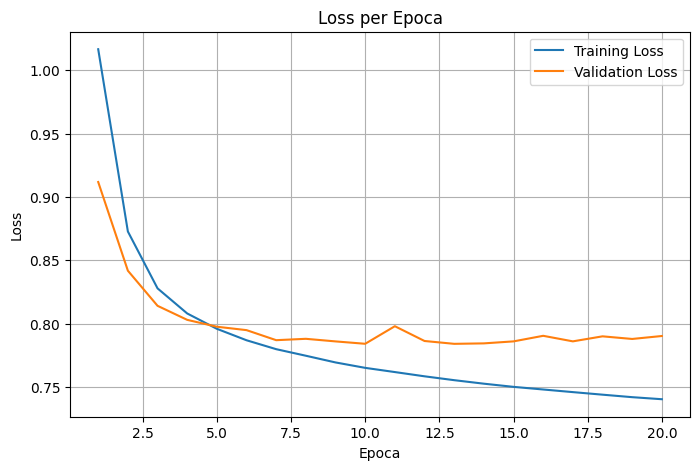

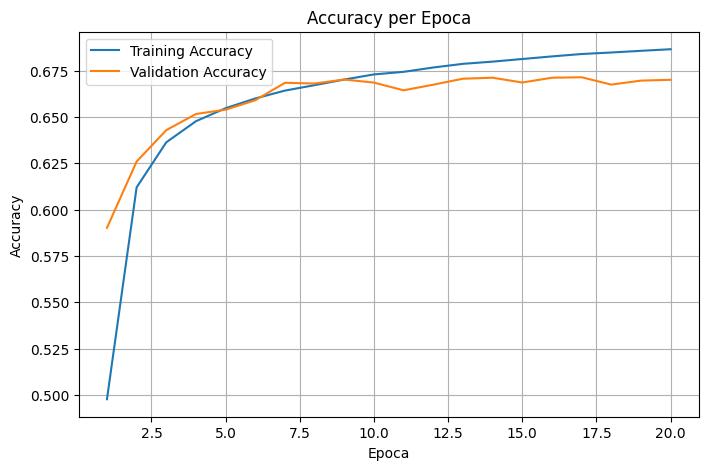

In [ ]:
epochs = range(1, len(base_model.train_loss_plot)+1)

plt.figure(figsize=(8,5))
plt.plot(epochs, base_model.train_loss_plot, label='Training Loss')
plt.plot(epochs, base_model.val_loss_plot, label='Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss per Epoca')
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, base_model.train_acc_plot, label='Training Accuracy')
plt.plot(epochs, base_model.val_acc_plot, label='Validation Accuracy')
plt.xlabel('Epoca')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Accuracy per Epoca')
plt.show()

Valutiamo la performance del modello sul test set. Carichiamo prima il miglior checkpoint.

In [ ]:
best_base_model_path = checkpoint_callback.best_model_path
best_base_model = BaseModel.load_from_checkpoint(best_base_model_path)

trainer.test(best_base_model, test_dl)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.666530966758728     │
│          test_f1          │    0.6640065908432007     │
│         test_loss         │     0.786811351776123     │
│      test_precision       │    0.6697068214416504     │
│        test_recall        │    0.6653420925140381     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.786811351776123,
  'test_acc': 0.666530966758728,
  'test_f1': 0.6640065908432007,
  'test_precision': 0.6697068214416504,
  'test_recall': 0.6653420925140381}]

In [ ]:
output = trainer.predict(best_base_model, dataloaders=test_dl)
output = torch.cat(output)
output = output.numpy()
predictions = output.argmax(axis=1)
wrong = y_test[y_test != predictions]

print(classification_report(y_test, predictions))

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.67      0.61      0.64      3237
           1       0.65      0.76      0.70      3368
           2       0.69      0.63      0.66      3219

    accuracy                           0.67      9824
   macro avg       0.67      0.67      0.66      9824
weighted avg       0.67      0.67      0.66      9824



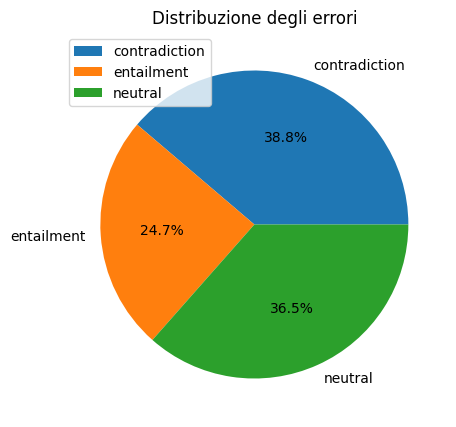

In [ ]:
label, data = np.unique(wrong, return_counts=True)
original_label = le.inverse_transform(label)

plt.figure(figsize=(8,5))
plt.pie(data, labels=original_label, autopct='%.1f%%')
plt.title('Distribuzione degli errori')
plt.legend()
plt.show()

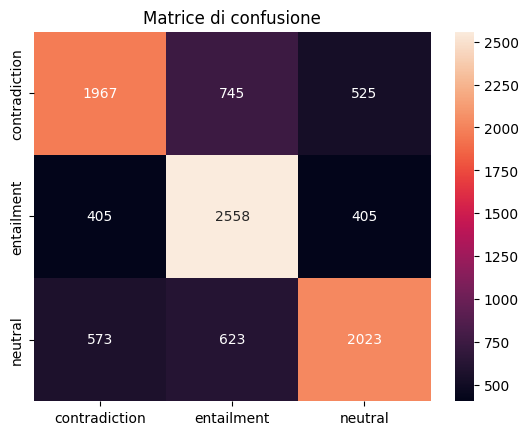

In [ ]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g', xticklabels=original_label, yticklabels=original_label).set_title('Matrice di confusione')
plt.show()

# Modello

In [ ]:
# Definiamo la classe del modello
class BetterModel(pl.LightningModule):
    def __init__(self, vocab_len, embedding_dim, embedding_matrix, hidden_dim, num_layers, dropout, lr, weight_decay):
        super(BetterModel, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_len, embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = True

        # Dropout no. 1 (subito dopo l'embedding)
        self.dropout_emb = nn.Dropout(dropout)

        # LSTM (bidirezionale)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True
        )


        # Classificatore
        self.classifier = nn.Sequential(
            nn.Linear(24 * hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 3)
        )

        # Funzione di loss, learning rate e weight decay
        self.loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.lr = lr
        self.weight_decay = weight_decay

        # Salviamo i log per usarli nei grafici
        self.train_loss_log = []
        self.train_acc_log = []
        self.val_loss_log = []
        self.val_acc_log = []

        self.train_loss_plot = []
        self.train_acc_plot = []
        self.val_loss_plot = []
        self.val_acc_plot = []

        self.save_hyperparameters()

    # Definiamo una funzione di supporto per applicare l'LSTM
    def encode(self, x):
        '''Prende in input una frase e applica l'LSTM al suo embedding.'''
        embedded = self.embedding(x)
        embedded = self.dropout_emb(embedded)

        output, (h_n, c_n) = self.lstm(embedded)

        # Estraiamo gli hidden state dell'ultimo layer per entrambe le direzioni
        # Prendiamo gli ultimi due vettori
        h_forward = h_n[-2, :, :]
        h_backward = h_n[-1, :, :]

        final = torch.cat((h_forward, h_backward), dim=1)

        # Pooling
        avg_pool = torch.mean(output, dim=1)
        max_pool, _ = torch.max(output, dim=1)

        # Combiniamo output dell'LSTM e pooling
        encoded = torch.cat((final, avg_pool, max_pool), dim=1)

        return encoded

    def forward(self, sent1, sent2):
        # Codifichiamo la premessa e l'ipotesi
        u = self.encode(sent1)
        v = self.encode(sent2)

        # Calcoliamo le interazioni tra le due rappresentazioni
        diff = torch.abs(u - v)
        prod = u * v

        # Combiniamo le rappresentazioni
        combined = torch.cat([u, v, diff, prod], dim=1)

        # Classificazione finale
        logits = self.classifier(combined)
        return logits

    def training_step(self, batch, batch_idx):
        sent1, sent2, label = batch
        output = self.forward(sent1, sent2)
        loss = self.loss_fn(output, label)
        accuracy = (output.argmax(dim=1) == label).float().mean()
        self.log('training_loss', loss, on_epoch=True, prog_bar=True)
        self.log('training_acc', accuracy, on_epoch=True, prog_bar=True)
        self.train_loss_log.append(loss)
        self.train_acc_log.append(accuracy)
        return loss

    def validation_step(self, batch, batch_idx):
        sent1, sent2, label = batch
        output = self.forward(sent1, sent2)
        loss = self.loss_fn(output, label)
        accuracy = (output.argmax(dim=1) == label).float().mean()
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', accuracy, on_epoch=True, prog_bar=True)
        self.val_loss_log.append(loss)
        self.val_acc_log.append(accuracy)
        return loss

    def test_step(self, batch, batch_idx):
        sent1, sent2, label = batch
        output = self.forward(sent1, sent2)
        loss = self.loss_fn(output, label)
        pred = output.argmax(dim=1)
        accuracy = (pred == label).float().mean()
        f1 = f1_score(label.cpu().numpy(), pred.cpu().numpy(), average='macro')
        precision = precision_score(label.cpu().numpy(), pred.cpu().numpy(), average='macro')
        recall = recall_score(label.cpu().numpy(), pred.cpu().numpy(), average='macro')

        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_acc', accuracy, on_epoch=True, prog_bar=True)
        self.log('test_f1', f1, on_epoch=True, prog_bar=False )
        self.log('test_precision', precision, on_epoch=True, prog_bar=False )
        self.log('test_recall', recall, on_epoch=True, prog_bar=False )

        return loss

    def predict_step(self, batch, batch_idx):
        sent1, sent2, _ = batch
        return self(sent1, sent2)

    def on_train_epoch_end(self):
        avg_loss = torch.stack(self.train_loss_log).mean()
        avg_acc = torch.stack(self.train_acc_log).mean()

        self.train_loss_plot.append(avg_loss.item())
        self.train_acc_plot.append(avg_acc.item())

        self.train_loss_log.clear()
        self.train_acc_log.clear()

    def on_validation_epoch_end(self):
        avg_loss = torch.stack(self.val_loss_log).mean()
        avg_acc = torch.stack(self.val_acc_log).mean()

        self.val_loss_plot.append(avg_loss.item())
        self.val_acc_plot.append(avg_acc.item())

        self.val_loss_log.clear()
        self.val_acc_log.clear()

    def configure_optimizers(self):    # Al posto di Adam usiamo AdamW
        return optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay, amsgrad=True)

Il codice per grid search:

```
param_grid = {
    'hidden_dim': [128, 256],
    'num_layers': [2, 3],
    'dropout': [0.3, 0.5],
    'lr': [1e-3, 5e-4],
    'weight_decay': [3e-5, 5e-5, 1e-4]
}

grid = ParameterGrid(param_grid)
```



```

results = []
for params in grid:
    checkpoint_callback = ModelCheckpoint(
        dirpath='checkpoints/',
        monitor='val_acc',
        mode='max',
        save_top_k=1
    )
    model = BetterModel(vocab_len,
                        embedding_dim,
                        embedding_matrix,
                        params['hidden_dim'],
                        params['num_layers'],
                        params['dropout'],
                        params['lr'],
                        params['weight_decay']
                       )
    trainer = pl.Trainer(max_epochs=15,
                         accelerator='auto',
                         devices='auto',
                         callbacks=[checkpoint_callback],
                         num_sanity_val_steps=0,
                         precision='16-mixed'
                        )
    trainer.fit(model, training_dl, val_dl)
    best_val_acc = checkpoint_callback.best_model_score.item()
    results.append((params, best_val_acc))
    
best_params = sorted(results, key=lambda x: x[1], reverse=True)[0]
print(f'Best parameters: {best_params[0]}, Validation Accuracy: {best_params[1]}')
```

Procediamo con il training

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints/',
    save_top_k=1,
    monitor='val_acc',
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_acc',
    min_delta=0.00,
    patience=5,
    verbose=True,
    mode='max'
)

In [ ]:
best_model = BetterModel(vocab_len,
                         embedding_dim,
                         embedding_matrix,
                         hidden_dim=256,
                         num_layers=2,
                         dropout=0.5,
                         lr=1e-3,
                         weight_decay=1e-4
                        )

In [ ]:
trainer = pl.Trainer(max_epochs=50,
                     accelerator='auto',
                     devices='auto',
                     callbacks=[early_stopping, checkpoint_callback],
                     num_sanity_val_steps=0,
                     precision='16-mixed',    # per velocizzare il training
                    )
trainer.fit(best_model, training_dl, val_dl)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | embedding   | Embedding        | 10.0 M | train
1 | dropout_emb | Dropout          | 0      | train
2 | lstm        | LSTM             | 2.7 M  | train
3 | classifier  | Sequential       | 1.6 M  | train
4 | loss_fn     | CrossEntropyLoss | 0      | train
-------

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.783


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.039 >= min_delta = 0.0. New best score: 0.821


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.009 >= min_delta = 0.0. New best score: 0.830


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.011 >= min_delta = 0.0. New best score: 0.841


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.007 >= min_delta = 0.0. New best score: 0.848


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.851


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.854


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.854


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.855


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.858


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 5 records. Best score: 0.858. Signaling Trainer to stop.


Carichiamo il miglior modello e lo testiamo.

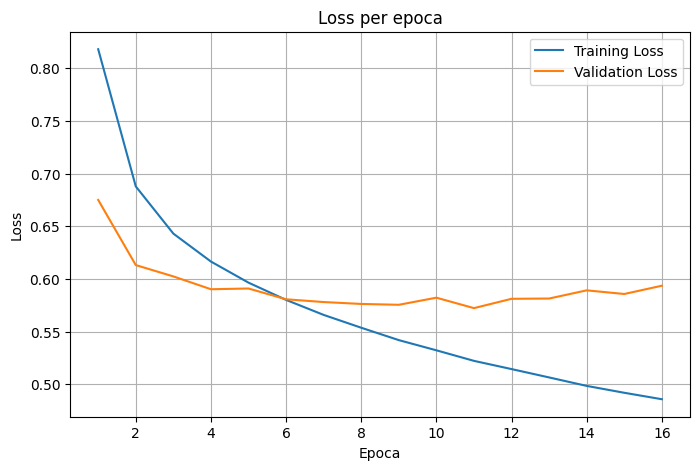

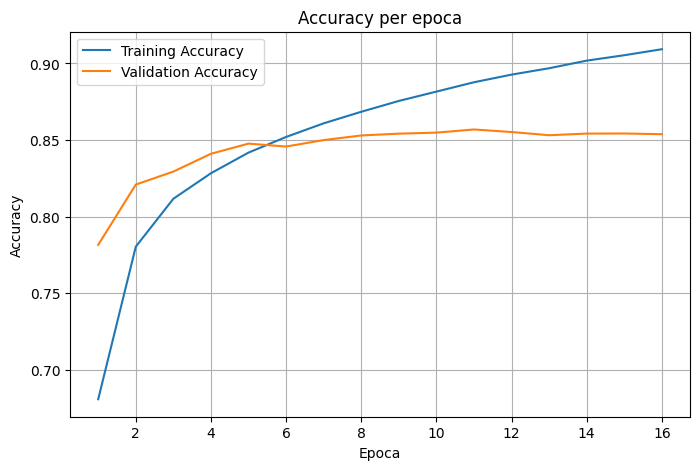

In [ ]:
epochs = range(1, len(best_model.train_loss_plot)+1)

plt.figure(figsize=(8,5))
plt.plot(epochs, best_model.train_loss_plot, label='Training Loss')
plt.plot(epochs, best_model.val_loss_plot, label='Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss per epoca')
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, best_model.train_acc_plot, label='Training Accuracy')
plt.plot(epochs, best_model.val_acc_plot, label='Validation Accuracy')
plt.xlabel('Epoca')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Accuracy per epoca')
plt.show()

In [ ]:
best_model_path = checkpoint_callback.best_model_path
best_model = BetterModel.load_from_checkpoint(best_model_path)

trainer.test(best_model, test_dl)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8519951105117798     │
│          test_f1          │    0.8511360287666321     │
│         test_loss         │     0.581697940826416     │
│      test_precision       │    0.8527235388755798     │
│        test_recall        │    0.8513448238372803     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.581697940826416,
  'test_acc': 0.8519951105117798,
  'test_f1': 0.8511360287666321,
  'test_precision': 0.8527235388755798,
  'test_recall': 0.8513448238372803}]

In [ ]:
output = trainer.predict(best_model, dataloaders=test_dl)
output = torch.cat(output)
output = output.numpy()
predictions = output.argmax(axis=1)
wrong = y_test[y_test != predictions]

print(classification_report(y_test, predictions))

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      3237
           1       0.84      0.90      0.87      3368
           2       0.83      0.79      0.81      3219

    accuracy                           0.85      9824
   macro avg       0.85      0.85      0.85      9824
weighted avg       0.85      0.85      0.85      9824



# Analisi degli errori

Diamo un'occhiata alla distribuzione degli errori tra le classi.

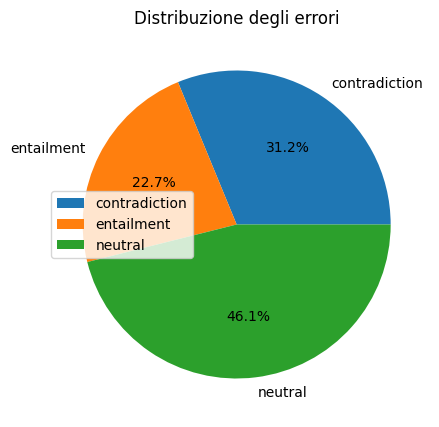

In [ ]:
label, data = np.unique(wrong, return_counts=True)
original_label = le.inverse_transform(label)

plt.figure(figsize=(8,5))
plt.pie(data, labels=original_label, autopct='%.1f%%')
plt.title('Distribuzione degli errori')
plt.legend()
plt.show()

Vediamo anche la matrice di confusione.

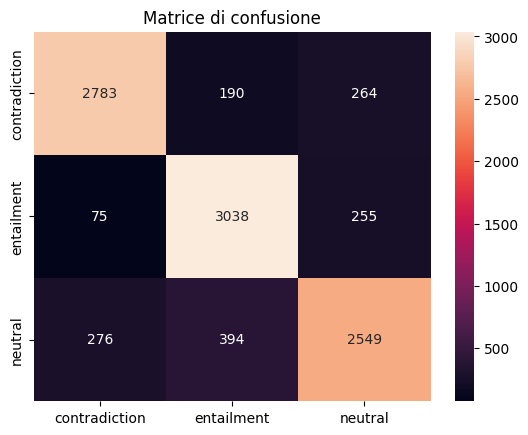

In [ ]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g', xticklabels=original_label, yticklabels=original_label).set_title('Matrice di confusione')
plt.show()

In [ ]:
errori = X_test
errori['preds'] = le.inverse_transform(predictions)
errori['true_label'] = le.inverse_transform(y_test)
errori = errori[y_test != predictions]
errori.head(50)

,sentence1,sentence2,preds,true_label
0,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,contradiction,neutral
5,"A woman with a green headscarf, blue shirt and...",The woman has been shot.,neutral,contradiction
8,An old man with a package poses in front of an...,A man walks by an ad.,entailment,contradiction
11,A statue at a museum that no seems to be looki...,Tons of people are gathered around the statue.,neutral,contradiction
12,A land rover is being driven across a river.,A Land Rover is splashing water as it crosses ...,neutral,entailment
20,A blond-haired doctor and her African american...,A doctor is studying,entailment,neutral
26,A young family enjoys feeling ocean waves lap ...,A family is at the beach.,neutral,entailment
31,3 young man in hoods standing in the middle of...,Three hood wearing people pose for a picture.,neutral,entailment
43,Male in a blue jacket decides to lay in the gr...,The guy wearing a blue jacket is laying on the...,neutral,entailment
68,A snowboarder on a wide plain of snow,A snowmobile in a blizzard,contradiction,neutral


# Relazione conclusiva

###Il Dataset
La target variable ‘gold_label’ assume 4 valori diversi: ‘entailment’, ‘contradiction’, ‘neutral’ e ‘-’. Quando non è ‘-’ ci sono due casi possibili: se le label da 2 a 5 sono assenti, ha lo stesso valore della label 1; altrimenti rappresenta la scelta della maggioranza degli annotatori (label da 1 a 5). Se il voto degli annotatori non è conclusivo, ‘gold_label’ è ‘-’. Notiamo che nella maggior parte dei casi le label da 2 a 5 sono assenti (oltre 510.000 sample sugli oltre 550.000 presenti nel training set); pertanto abbiamo deciso di eliminare le colonne rappresentanti le annotazioni Inoltre abbiamo eliminato le colonne contenenti il parse e il binary parse delle frasi perché abbiamo deciso di lavorare solo con la rappresentazione sequenziale delle frasi e non con con la struttura sintattica. Quindi abbiamo tenuto solo ‘gold_label’, ‘sentence1’ e ‘sentence2’. Abbiamo eliminato i sample contenenti un trattino come etichetta, dopo aver verificato che rappresentavano solo una percentuale trascurabile dei sample totali; abbiamo anche eliminato i pochi sample (6) in cui l’ipotesi (‘sentence2’) era completamente assente.
I dati erano già suddivisi in tre file diversi per il training, il validation e il test set. Abbiamo verificato che sia la distribuzione delle etichette che la lunghezza media della premessa e dell’ipotesi sono simili in tutti e tre.

###L’embedding
Abbiamo scelto di usare i vettori preaddestrati di GloVe per l’embedding; abbiamo provato a utilizzare sia i vettori di dimensione 100 che quelli di dimensione 300 e abbiamo notato un significativo miglioramento della performance con quelli di dimensione maggiore. Per utilizzarli abbiamo costruito un vocabolario tokenizzando le parole presenti nel corpus utilizzando semplicemente le espressioni regolari; abbiamo preferito questo metodo a tokenizzazioni più sofisticate perché l’uso delle espressioni regolari è computazionalmente più efficiente e la performance del modello non ne ha risentito, dal momento che le frasi non presentano caratteri speciali e la poca punteggiatura presente non è rilevante per il task.

###Dataset e Dataloader
All’interno della classe del dataset, nella funzione __getitem__, tokenizziamo la premessa e l’ipotesi e, tramite una funzione di supporto definita appositamente, restituiamo un vettore contenente gli indici associati nel vocabolario costruito precedentemente. Abbiamo scelto di impostare la batch size a 512 perché ci è sembrato il miglior compromesso tra performance e velocità dell’addestramento.

###Modello base
Il nostro modello base è una semplice rete neurale costituita da un layer di embedding, in cui abbiamo reso addestrabile la matrice degli embedding; l’embedding delle due frasi avviene separatamente, e su ciascun output applichiamo il mean pooling. I due tensori risultanti da questa operazione vengono concatenati lungo l’asse dell’embedding_dim, e infine applichiamo un layer lineare finale, che insieme alla funzione di loss scelta, Cross Entropy Loss, può essere visto come una regressione logistica multiclasse. Come ottimizzatore abbiamo scelto Adam.
Per velocizzare l’addestramento del modello abbiamo deciso di utilizzare la mixed precision a 16 bit; abbiamo anche implementato l’early stopping basato sulla validation accuracy. Nonostante la sua semplicità, il modello raggiunge dei discreti risultati; infatti, l’accuracy sul test set si attesta intorno al 66%. Dal momento che le etichette sono molto ben bilanciate f1, precision e recall sono molto vicine al valore dell’accuracy.

###BiLSTM
La soluzione migliorativa che abbiamo pensato si basa su un LSTM bidirezionale. Innanzitutto c’è, come nel caso precedente, un layer di embedding con la matrice di embedding addestrabile. L’embedding avviene separatamente per premessa e ipotesi nella funzione di supporto encode; abbiamo aggiunto anche un layer di dropout per un maggiore effetto regolarizzante sul modello. Ciascuna frase è poi data in input a un LSTM bidirezionale con hidden_dim pari a 256 e con 2 layer (questi sono gli iperparametri selezionati tramite grid search). Dal risultato estraiamo gli hidden state dell’ultimo layer, sia forward che reverse, e li concateniamo; a questo concateniamo poi anche la media e il massimo  dell’output calcolati lungo dim=1 (la lunghezza delle sequenze). In questo caso utilizziamo il pooling per aggiungere più informazioni che identifichino ciascuna frase; in questo modo otteniamo una rappresentazione più sofisticata. In forward applichiamo encode a premessa e ipotesi; calcoliamo poi le interazioni tra le due, in particolare il valore assoluto della differenza e il prodotto di Hadamard (punto per punto) delle due rappresentazioni. La nostra idea si basa infatti sulla similarità tra le due frasi, e questo è un modo abbastanza semplice di implementarla nel nostro modello. Abbiamo provato a utilizzare invece la similarità del coseno, ma la performance era peggiore; probabilmente usare sia la differenza che il prodotto tra le due rappresentazioni permette di cogliere più aspetti della similarità (o dissimilarità) tra le frasi. Infine abbiamo concatenato le rappresentazioni delle due frasi e le due interazioni, e le abbiamo date in input a una sequenza composta da un layer lineare, ReLU, un layer di dropout e un layer lineare finale. La funzione di loss che abbiamo utilizzato è anche in questo caso Cross Entropy Loss, mentre come ottimizzatore abbiamo usato AdamW, in particolare nella sua variante AMSGrad, che applicando il weight decay direttamente nell’aggiornamento dei parametri e non alla loss come Adam (regolarizzazione L2)  ha ridotto di molto la velocità con cui il modello va in overfitting.
L’accuracy del modello è abbastanza alta, così come lo sono precision, recall e f1. Guardando però il classification report notiamo che la performance è diversa sulle tre classi; la maggior parte degli errori viene fatta per la classe ‘neutral’; sia precision che recall sono infatti di diversi punti più basse rispetto a ‘contradiction’ e ‘entailment’. A parte alcuni casi in cui l’ambiguità delle frasi rende il lavoro difficile anche per un essere umano, guardando i sample che il modello classifica male sembra che spesso si tratti di casi in cui la premessa e l’ipotesi presentano molte delle stesse parole. Questo potrebbe significare che ci siamo concentrati troppo sulla similarità tra le frasi e che bisognerebbe trovare un modo migliore per catturare meglio le differenze tra premessa e ipotesi, o forse che servirebbe un modo migliore per rappresentare le frasi.

###Possibili miglioramenti
Per migliorare la performance del modello senza stravolgerne l’architettura secondo noi si può lavorare su due fronti. Il primo è quello della rappresentazione delle frasi, che potrebbe essere resa più sofisticata per esempio aggiungendo delle informazioni sulla struttura sintattica della frase; l’analisi degli errori mostra che il punto debole del modello è più probabilmente l’aspetto semantico, ma l’aggiunta di questo genere di informazione potrebbe comunque contribuire a migliorarne le prestazioni. L’altro fronte riguarda proprio l’aspetto semantico: si potrebbe cercare un modo migliore per catturare la similarità ma soprattutto la differenza tra le frasi. Inoltre, dall’analisi degli errori emerge che spesso il modello sbaglia a classificare sample in cui la premessa e l’ipotesi sono uguali a meno di una o due parole che però cambiano di molto il significato delle frasi e quindi la relazione tra le due; potrebbe quindi essere utile implementare un meccanismo che non tenga conto solo della similarità tra le intere frasi, ma anche delle singole parole, magari quelle più rilevanti.
